### Solid Waste Engineering 2018
#### Book 2 of x see notebook Solid Waste Engineering 2018
#### Semester project: Testing the probability of garbage
Masters students in Environmental Engineering from the [École Polytechnique Féderale de Lausanne](https://enac.epfl.ch/environmental-engineering) test the hypothesis that litter densities on Lac Léman are predicatable.  The current method is based on the Probability Density Function derived from the logarithm of the pieces/meter of trash (pcs/m) from over 100 samples.

#### Purpose: Understanding how the results from one inventory relate to the rest of the inventories for the lake.

1. Getting data from the API
2. Reporting descriptive statistics
3. Comparing results on the lake
4. Graphing results

We will add to this workbook as the semester advances

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import seaborn
import requests
import json

### This is all the daily totals in the database for Lac Léman:
The api makes this operation very straight forward it can be put into a dataFrame directly.

In [2]:
# make a function to get data
# we will hit the api more than once
def getData(url):
    a = url
    c = requests.get(url).json()
    d = pd.DataFrame(c)
    return d

In [3]:
this_data = getData("http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json")
# the pcs/m ratio is not stored in the database and therefore needs to be calculated
this_data["pcs_m"]=this_data.total / this_data.length
# make a copy and give it a name that is easier to recognize:
dailyTotalsLac = this_data.copy()
colNameTotals = list(dailyTotalsLac.columns)
# one record from the df
dailyTotalsLac.iloc[0]

date                2015-11-23
length                      61
location    Baye-de-Montreux-G
total                      349
pcs_m                  5.72131
Name: 0, dtype: object

### This is all the beaches in the database for Lac Léman:
This gives all the geo information for each beach in the data base:

In [4]:
beach_data = getData("http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/")
beachData = beach_data.copy()
beachColumns = list(beachData.columns)
# one record from the df
beachData.iloc[0]

city          La-Tour-de-Peilz
latitude           46.44721600
location         Anarchy-Beach
longitude           6.85961200
owner                 mwshovel
post                      1814
project_id                MCBP
water                        l
water_name           Lac-Léman
Name: 0, dtype: object

### Getting the object information for each inventory
The inventories are stored in a non aggregated form.

In [5]:
code_data = getData("https://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/")
codeData = code_data.copy()
codeColumns = list(codeData.columns)
codeData.iloc[0]

code_id                      G100
date                   2015-11-23
length                         61
location_id    Baye-de-Montreux-G
owner                    mwshovel
project_id                   MCBP
quantity                        1
Name: 0, dtype: object

### This gets the MLW codes from the website:

In [6]:
csvUrl = "https://mwshovel.pythonanywhere.com/static/newCriteria.csv"
mlwCodes = pd.read_csv(csvUrl)
mlwCodes.iloc[0]

code                       G1
material              Plastic
description    Six pack rings
source                   Food
Name: 0, dtype: object

### The descriptive statistics for each beach on the lake and for the lake
This data is available on the api also

In [7]:
# make a function to get all the results in a dictionary:
url_x = "http://mwshovel.pythonanywhere.com/dirt/summary" #<--- need to add the following "/beach or lake/?format=json"
beachNames = list(beachData.location)
cities = list(beachData.city.unique())


In [8]:
def getSummaries(aList):
    c = {}
    for x in aList:
        a = str(url_x + "/" + str(x) + "/?format=json")
        b = requests.get(a).json()
        d = {x:b}
        c.update(d)
    return c
beachSummaries = getSummaries(beachNames)
citySummaries = getSummaries(cities)
lakeSummary = getSummaries(['Lac-Léman'])

In [9]:
# so if that works we should be able to do something like this:
print(cities[3])
print(citySummaries[cities[3]])
# that looks good!

Tolochenaz
{'num_locs': 1, 'total': 402, 'num_samps': 1, 'first': '2016-04', 'last': '2016-04', 'ave_dense': '3.2683', 'max_dense': '3.2683', 'min_dense': '3.2683', 'two_five': '3.2683', 'seven_five': '3.2683', 'num_lakes': 1, 'num_rivers': 0, 'stan_dev': '0.0000', 'location': 'Tolochenaz'}


### Item comparisons

How does the composition of items found at Tiger-duck-beach (TDB) compare to the previous results?

In [10]:
# we can do this like this because there is only one inventory for Tiger-duck-beach: 
tDB = codeData.loc[codeData.location_id == "Tiger-duck-beach"].copy()
codesTDB = list(tDB.code_id)
numberOfCodes = len(codesTDB)

### Histogram of code counts from all inventories on the lake

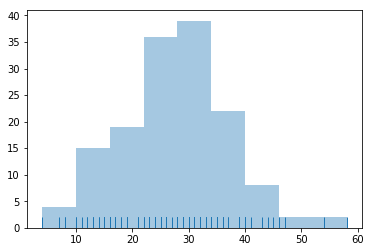

In [25]:
#get that value from the other locations:
codesGroupedDate = pd.DataFrame(codeData['quantity'].groupby([codeData['location_id'],codeData['date'], codeData['code_id']]).sum())
codeCounts = codesGroupedDate.groupby(['location_id', 'date']).count()
seaborn.distplot(codeCounts, bins=9, kde=False, rug=True);

In [12]:
#  see how the number of categories compares:
codeCounts.describe()

,quantity
count,147.000000
mean,26.904762
std,9.482019
min,4.000000
25%,21.000000
50%,27.000000
75%,33.000000
max,58.000000


#### So the number of categories indentified at Tiger-duck-beach is right around the 50th percentile for the lake.

### If the number of categories was in the 50th percentile how do the catgegory results compare?

### Was there one item in particular that caused the extreme pcs/m value for the day ?

### Or was it a combination of many items ?

In [13]:
# get the codes in pieces per meter:
tDB['pcs_m'] = tDB.quantity/tDB.length
codeData['pcs_m']  = codeData.quantity/codeData.length
# reduce the data to only those codes indentified at TDB
tdBCodeData = codeData.loc[codeData.code_id.isin(codesTDB)]
# remove any values = 0 
tdBCodeData = tdBCodeData[tdBCodeData['pcs_m'] > 0]
# get the log of pcs_m, its a scale thing for charting
tdBCodeData['ln_pcs'] = np.log(tdBCodeData['pcs_m'])

In [14]:
# Select any records from TDB that are greater than the some percentile
def getGreaterThan(aList, p):
    c = []
    for b in aList:
        a = tdBCodeData.loc[tdBCodeData.code_id == b ][['location_id','code_id', 'pcs_m']]
        e = a.pcs_m.quantile(p)
        f = a[(a.location_id == "Tiger-duck-beach") & (a.pcs_m > e)]
        # grab the value that is greater than the desired %
        if len(f['pcs_m'].values) > 0:
            c.append((b,e,f['pcs_m'].values[0]))
    return c
# choose the seventy fifth etc..:
seventyFifth = getGreaterThan(codesTDB, .75)
ninetyFifth = getGreaterThan(codesTDB, .95)
ninetyNinth = getGreaterThan(codesTDB, .99)
print(len(seventyFifth), len(ninetyFifth), len(ninetyNinth))

25 19 9


### 25 of the 30 categories exceeded the 75th percentile for all previous samples on the lake.

There was a variety of objects that caused the extreme value. Looking at the 99th percentile and greater, there are nine categories that meet this criteria.

Lets take a look:

In [15]:
crazy99 = [x[0] for x in ninetyNinth]
print(crazy99)

['G24', 'G21', 'G32', 'G89', 'G93', 'G100', 'G137', 'G87', 'G79']


### Take a look at the boxplot of all results for those nine categories:

In [16]:
# first we need to get some colors for our charts:
import random
xkcd_colors = list(seaborn.xkcd_rgb.keys())
these_colors = random.sample(xkcd_colors, 34)
random_colors = seaborn.xkcd_palette(these_colors)

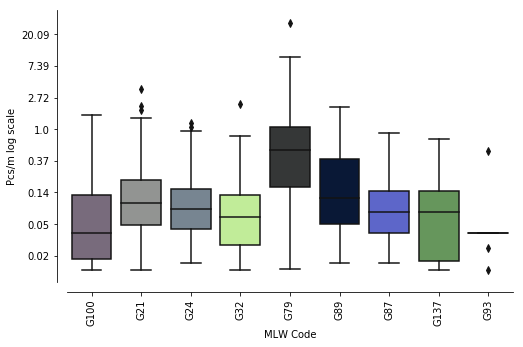

In [20]:
theNinetyNine = tdBCodeData.loc[tdBCodeData.code_id.isin(crazy99)]
# use the log otherwise the scale is way out their
ax = seaborn.boxplot(x="code_id", y="ln_pcs", palette=random_colors, data=theNinetyNine)
fig = plt.gcf()
x_tick_labels = []
seaborn.despine(offset=10)
for label in ax.get_xticklabels():
    label.set_rotation(90)
for label in ax.get_yticks():
    label = round(np.exp(label), 2)
    x_tick_labels.append(label)
ax.set_yticklabels(x_tick_labels)
ax.set(xlabel='MLW Code', ylabel='Pcs/m log scale')

fig.set_size_inches(8,5)
plt.show()

### Okay so what are those nine codes?

1. What industry are they from? Material type? Descritption?

In [18]:
nineCodes = mlwCodes.loc[mlwCodes.code.isin(crazy99)]
print(nineCodes[['code', 'material', 'description']])

     code material                  description
20    G21  Plastic                   Drink lids
23    G24  Plastic      Plastic rings from lids
31    G32  Plastic           Toys and fireworks
78    G79  Plastic  Plastic pieces 2.5 > < 50cm
86    G87  Plastic                 Masking tape
88    G89  Plastic   Plastic construction waste
92    G93  Plastic                  Cable ties 
99   G100  Plastic           Medical containers
136  G137    Cloth  Clothing, rags, hats etc.,,


### Discussion:

The biggest change is from G79 -- "Plastic Pieces", and the presence of G93 -- "Cable ties". Apparently G93 had not been identified on the lake previously. This is not likeley and they were probably placed in another category like "Strapping bands".

Nonetheless Fragmented plastics make up almost 50% of the total pcs/m. In general on the lake fragmented plastics are about 12% of the total. 

### Take a look at how the pcs/m is distributed for all categories in the Tiger-duck-beach inventory:

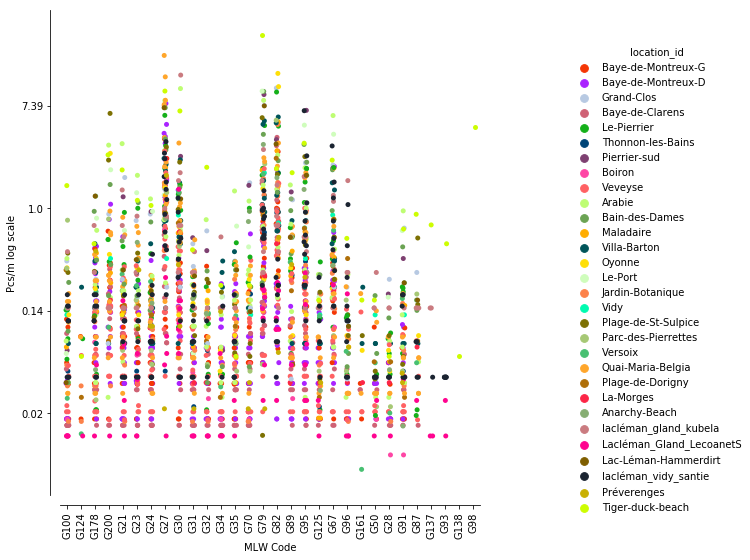

In [21]:
these_colors = random.sample(xkcd_colors, 34)
random_colors = seaborn.xkcd_palette(these_colors)

g = seaborn.catplot(x="code_id", y="ln_pcs", data=tdBCodeData, aspect=1,hue="location_id", palette=random_colors, legend_out=True,)

fig = plt.gcf()
x_tick_labels = []

    
seaborn.despine(offset=10)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for label in ax.get_yticks():
        label = round(np.exp(label), 2)
        x_tick_labels.append(label)
    ax.set_yticklabels(x_tick_labels)
ax.set(xlabel='MLW Code', ylabel='Pcs/m log scale')
fig.set_size_inches(11, 8)
plt.show()
